<a href="https://colab.research.google.com/github/hhh6593/TIL/blob/master/pytorch_chap4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [6]:
#딥러닝 모델 설계 시 활용하는 장비 확인
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


In [7]:
batch_size = 32 #mini batch 하나 당 32개의 데이터로 구성됌
epochs = 10 #반복 횟수

In [24]:
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True) #이미지가 아닌 순서로 훈련을 하는 잘못된 방향으로 나아가는 것을 방지하기 위해 순서를 섞는 것.

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

Files already downloaded and verified


In [25]:
#데이터 확인하기 1
for (x_train, y_train) in train_loader:
    print('x_train :', x_train.size, 'tpye :',x_train.type())
    print('y_train :', y_train.size, 'type :',y_train.type())
    break

x_train : <built-in method size of Tensor object at 0x7f5e34296230> tpye : torch.FloatTensor
y_train : <built-in method size of Tensor object at 0x7f5e34e5d640> type : torch.LongTensor


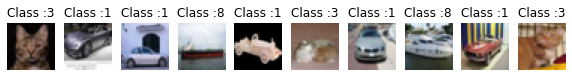

In [26]:
#데이터 확인하기 2 (시각화)
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i],(1, 2, 0)))
    plt.title('Class :'+str(y_train[i].item()))

In [27]:
#MLP 모델 설계
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  #nn.Module에 있는 모델을 상속받아 사용
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  #가로 픽셀 수 * 세로 픽셀 수 * 채널 수, 두번째 Fully Connected Layer(fcl) 노드 수 512개
        self.fc2 = nn.Linear(512, 256) #세번째 fcl의 노드수를 256개로 설정
        self.fc3 = nn.Linear(256, 10)  #output 노드 수 10개로 설정(클래스가 10개로 나뉘기 때문)

    def forward(self, x):  #역전파 정의
        x = x.view(-1, 32 * 32 * 3) #MLP모델은 1차원 벡터 값을 입력값으로 받기 때문에 2차원의 이미지 데이터를 1차원으로 변환(Flatten)
        x = self.fc1(x) #첫번째 fcl에 1차원 데이터 통과
        x = F.relu(x)   #ReLu 활성화 함수 적용
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) #최종 output 계산
        return x

In [28]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) #역전파에 이용될 옵티마이저 정의
criterion= nn.CrossEntropyLoss() #output값이 onehotencoding으로 계산되어 이의 loss값을 계산하기 위한 crossentropy 정의

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [29]:
#모델 성능을 확인하기 위한 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch : {} [{}/{}({:.0f}%)] \tTrain Loss : {:.6f}'.format(epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [30]:
def evaluate(model, test_loader):
    model.train()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [31]:
for epoch in range(1, epochs + 1):
    train(model, train_loader ,optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} % \n'.format(epoch, test_loss, test_accuracy))

Train Epoch : 1 [0/50000(0%)] 	Train Loss : 2.304235
Train Epoch : 1 [6400/50000(13%)] 	Train Loss : 1.845717
Train Epoch : 1 [12800/50000(26%)] 	Train Loss : 1.737504
Train Epoch : 1 [19200/50000(38%)] 	Train Loss : 1.722758
Train Epoch : 1 [25600/50000(51%)] 	Train Loss : 1.700278
Train Epoch : 1 [32000/50000(64%)] 	Train Loss : 2.007380
Train Epoch : 1 [38400/50000(77%)] 	Train Loss : 1.812425
Train Epoch : 1 [44800/50000(90%)] 	Train Loss : 1.989174

[EPOCH : 1], 	Test Loss : 0.0524, 	Test Accuracy : 39.64 % 

Train Epoch : 2 [0/50000(0%)] 	Train Loss : 1.629825
Train Epoch : 2 [6400/50000(13%)] 	Train Loss : 1.539872
Train Epoch : 2 [12800/50000(26%)] 	Train Loss : 1.865979
Train Epoch : 2 [19200/50000(38%)] 	Train Loss : 1.541514
Train Epoch : 2 [25600/50000(51%)] 	Train Loss : 1.894360
Train Epoch : 2 [32000/50000(64%)] 	Train Loss : 1.983631
Train Epoch : 2 [38400/50000(77%)] 	Train Loss : 1.458342
Train Epoch : 2 [44800/50000(90%)] 	Train Loss : 1.585645

[EPOCH : 2], 	Test Lo

In [43]:
#CNN 모델링
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d( #convolution 연산을 하는 filter 정의
            in_channels = 3,  #이미지의 채널수와 동일하게 맞춰주어야 함(RGB = 3)
            out_channels = 8, #feature map을 8개로 설정
            kernel_size = 3,  #filter size
            padding = 1) #이미지의 구석부분이 상대적으로 덜 연산되기 때문에 가장자리를 0으로 채워주는 것
        self.conv2 = nn.Conv2d(
            in_channels = 8, #feature map의 채널 수와 동일하게 설정
            out_channels = 16, #feature map의 개수 설정
            kernel_size = 3,
            padding = 1)
        self.pool = nn.MaxPool2d( #차원의 크기를 줄이기 위해 filter의 최대값만을 뽑늑 서
            kernel_size = 2,
            stride = 2) #filter가 maxpooling 과정에서 움직이는 단위 설정
        self.fc1 = nn.Linear(8 * 8 * 16, 64) #conv1과 conv2 연산을 이용한 결과를 바탕으로 생성된 feature map의 크기 (forward에서 계산된 결과), 두번째 노드 수 64
        self.fc2 = nn.Linear(64, 32) #세번째 노드 수 32
        self.fc3 = nn.Linear(32, 10) #output 노드 수 10개
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x


In [44]:
model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion= nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [45]:
for epoch in range(1, epochs + 1):
    train(model, train_loader ,optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} % \n'.format(epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch : 1 [0/50000(0%)] 	Train Loss : 2.296816
Train Epoch : 1 [6400/50000(13%)] 	Train Loss : 1.924620
Train Epoch : 1 [12800/50000(26%)] 	Train Loss : 2.092261
Train Epoch : 1 [19200/50000(38%)] 	Train Loss : 1.675307
Train Epoch : 1 [25600/50000(51%)] 	Train Loss : 1.398693
Train Epoch : 1 [32000/50000(64%)] 	Train Loss : 1.374489
Train Epoch : 1 [38400/50000(77%)] 	Train Loss : 1.556710
Train Epoch : 1 [44800/50000(90%)] 	Train Loss : 1.687429

[EPOCH : 1], 	Test Loss : 0.0443, 	Test Accuracy : 49.32 % 

Train Epoch : 2 [0/50000(0%)] 	Train Loss : 1.333099
Train Epoch : 2 [6400/50000(13%)] 	Train Loss : 1.373902
Train Epoch : 2 [12800/50000(26%)] 	Train Loss : 1.117997
Train Epoch : 2 [19200/50000(38%)] 	Train Loss : 1.322187
Train Epoch : 2 [25600/50000(51%)] 	Train Loss : 0.997992
Train Epoch : 2 [32000/50000(64%)] 	Train Loss : 1.581158
Train Epoch : 2 [38400/50000(77%)] 	Train Loss : 1.391220
Train Epoch : 2 [44800/50000(90%)] 	Train Loss : 1.059219

[EPOCH : 2], 	Test Lo

In [58]:
#데이터 증감 - Data Augmentation - 데이터 inbalance를 맞춰주기 위한 기법
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([transforms.RandomCrop(16),
                                                                 transforms.RandomHorizontalFlip(),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = False,
                                transform = transforms.Compose([
                                                                 transforms.RandomHorizontalFlip(),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

Files already downloaded and verified


In [60]:
import torchvision

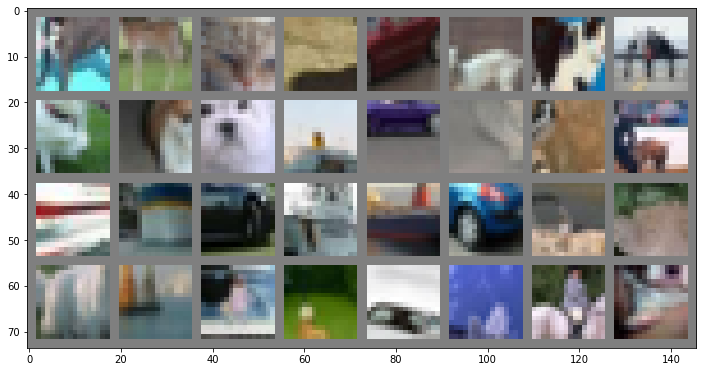

In [61]:
#데이터 증강 시각화
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(12,10))
imshow(torchvision.utils.make_grid(images))
plt.show()

In [50]:
for epoch in range(1, epochs + 1):
    train(model, train_loader ,optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} % \n'.format(epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch : 1 [0/50000(0%)] 	Train Loss : 2.190090
Train Epoch : 1 [6400/50000(13%)] 	Train Loss : 0.948573
Train Epoch : 1 [12800/50000(26%)] 	Train Loss : 1.297717
Train Epoch : 1 [19200/50000(38%)] 	Train Loss : 1.016951
Train Epoch : 1 [25600/50000(51%)] 	Train Loss : 0.853927
Train Epoch : 1 [32000/50000(64%)] 	Train Loss : 0.850125
Train Epoch : 1 [38400/50000(77%)] 	Train Loss : 0.789361
Train Epoch : 1 [44800/50000(90%)] 	Train Loss : 0.863423

[EPOCH : 1], 	Test Loss : 0.0324, 	Test Accuracy : 63.93 % 

Train Epoch : 2 [0/50000(0%)] 	Train Loss : 1.027305
Train Epoch : 2 [6400/50000(13%)] 	Train Loss : 0.653336
Train Epoch : 2 [12800/50000(26%)] 	Train Loss : 0.963527
Train Epoch : 2 [19200/50000(38%)] 	Train Loss : 1.031267
Train Epoch : 2 [25600/50000(51%)] 	Train Loss : 1.121586
Train Epoch : 2 [32000/50000(64%)] 	Train Loss : 1.043623
Train Epoch : 2 [38400/50000(77%)] 	Train Loss : 0.816980
Train Epoch : 2 [44800/50000(90%)] 	Train Loss : 0.907581

[EPOCH : 2], 	Test Lo